In [34]:
import os
import tqdm
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

plt.rcParams["font.sans-serif"] = ["SimHei"]
matplotlib.rcParams["axes.unicode_minus"] = False
five_mins_data = pd.read_table(
    "./HSI_5分钟线.txt", encoding="gb18030", skiprows=1, dtype=str
)
five_mins_data = five_mins_data.iloc[:-1]
five_mins_data.columns = five_mins_data.columns.str.strip()
five_mins_data["收盘"] = five_mins_data["收盘"].astype(float)
five_mins_data["日期时间"] = five_mins_data["日期"] + " " + five_mins_data["时间"]
five_mins_data["日期时间"] = pd.to_datetime(five_mins_data["日期时间"])
five_mins_data


def calculate_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    average_gain = up.rolling(window=window).mean()
    average_loss = abs(down.rolling(window=window).mean())

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


rsi = calculate_rsi(five_mins_data["收盘"], 14)
close = five_mins_data["收盘"]

# 计算 RSV
low_list = pd.Series.rolling(close, window=9).min()
high_list = pd.Series.rolling(close, window=9).max()
rsv = (close - low_list) / (high_list - low_list) * 100

# 计算 KDJ
K = pd.Series.ewm(rsv, adjust=False, alpha=1 / 3).mean()
D = pd.Series.ewm(K, adjust=False, alpha=1 / 3).mean()
J = 3 * K - 2 * D

# 将 KDJ 添加到 series_df
five_mins_data["K"] = K
five_mins_data["D"] = D
five_mins_data["J"] = J

short_term_window = 12
long_term_window = 26

short_term_ema = (
    five_mins_data["收盘"].rolling(window=short_term_window, min_periods=1).mean()
)
long_term_ema = (
    five_mins_data["收盘"].rolling(window=long_term_window, min_periods=1).mean()
)


macd_line = short_term_ema - long_term_ema
signal_line = macd_line.rolling(window=9, min_periods=1).mean()

macd_baseline = macd_line - signal_line

In [35]:
def calculate_buy_signal(data):
    data["mavg"] = data["收盘"].rolling(100).mean()
    buy_signal = (data["收盘"].shift(1) < data["mavg"].shift(1)) & (
        data["收盘"] > data["mavg"]
    )

    return buy_signal


def calculate_sell_price(buy_price, close_price):
    sell_price = close_price
    return sell_price

In [36]:
buy_signal = calculate_buy_signal(five_mins_data)

buy_price = None
sell_price = None
total_profit = 0
mymoney = 1000000
cnt = 0
haveday = 0
money_list = []
for index, row in five_mins_data.iterrows():
    if index < 30200:
        continue
    if (
        buy_signal[index]
        and row["J"] > 80
        and macd_baseline[index] > macd_baseline[index - 1]
    ):
        if buy_price is None:
            buy_price = row["收盘"]
            buy_time = row["时间"]
            buy_data = row["日期"]
            num = mymoney // buy_price
            cnt += num
            print(f"买入股票：{buy_price}，数量：{num}，日期：{buy_data}，时间：{buy_time}")
            mymoney -= num * buy_price
            print(f"剩余金额:{mymoney}")
            money_list.append(mymoney + cnt * row["收盘"])
            nowmoney = mymoney + cnt * row["收盘"]
    haveday += 1
    if buy_price is not None:
        # 更新卖出价格为当天的收盘价
        sell_price = calculate_sell_price(buy_price, row["收盘"])
        sell_time = row["时间"]
        sell_data = row["日期"]

        if sell_price > buy_price:
            print(f"卖出股票：{sell_price}，数量：{num}，日期：{sell_data}，时间：{sell_time}")
            mymoney += cnt * sell_price
            cnt = 0
            print(f"剩余金额:{mymoney}")
            profit = sell_price - buy_price
            total_profit += profit
            print(f"利润：{profit}")
            buy_price = None
            sell_price = None
            haveday = 0
            money_list.append(mymoney)
            nowmoney = mymoney
        if haveday > 66 * 60 and macd_baseline[index] < macd_baseline[index - 1]:
            print(f"卖出股票：{sell_price}，数量：{num}，日期：{sell_data}，时间：{sell_time}")
            mymoney += cnt * sell_price
            cnt = 0
            print(f"剩余金额:{mymoney}")
            profit = sell_price - buy_price
            total_profit += profit
            print(f"利润：{profit}")
            buy_price = None
            sell_price = None
            haveday = 0
            money_list.append(mymoney)

买入股票：26111.79，数量：38.0，日期：2020-11-13，时间：1440
剩余金额:7751.979999999981
卖出股票：26156.86，数量：38.0，日期：2020-11-13，时间：1600
剩余金额:1001712.66
利润：45.06999999999971
买入股票：26451.54，数量：37.0，日期：2020-11-20，时间：1600
剩余金额:23005.68000000005
卖出股票：26554.96，数量：37.0，日期：2020-11-23，时间：0935
剩余金额:1005539.2000000001
利润：103.41999999999825
买入股票：26454.16，数量：38.0，日期：2020-11-23，时间：1315
剩余金额:281.12000000011176
卖出股票：26456.5，数量：38.0，日期：2020-11-23，时间：1355
剩余金额:1005628.1200000001
利润：2.3400000000001455
买入股票：26469.79，数量：37.0，日期：2020-11-24，时间：1015
剩余金额:26245.89000000013
卖出股票：26474.8，数量：37.0，日期：2020-11-24，时间：1020
剩余金额:1005813.4900000001
利润：5.009999999998399
买入股票：26735.84，数量：37.0，日期：2020-11-26，时间：1400
剩余金额:16587.41000000015
卖出股票：26743.91，数量：37.0，日期：2020-11-26，时间：1445
剩余金额:1006112.0800000002
利润：8.069999999999709
买入股票：26527.51，数量：37.0，日期：2020-12-02，时间：1055
剩余金额:24594.210000000196
卖出股票：26539.11，数量：37.0，日期：2020-12-02，时间：1110
剩余金额:1006541.2800000003
利润：11.600000000002183
买入股票：26560.79，数量：37.0，日期：2020-12-02，时间：1430
剩余金额:23792.05000000028
卖出

In [37]:
# 最后一天全部卖出，计算收益
print(f"卖出股票：{sell_price}，数量：{num}，日期：{sell_data}，时间：{sell_time}")
mymoney += cnt * sell_price
cnt = 0
print(f"剩余金额:{mymoney}")
profit = sell_price - buy_price
total_profit += profit
buy_price = None
sell_price = None
haveday = 0
money_list.append(mymoney)

卖出股票：17454.19，数量：65.0，日期：2023-11-17，时间：1600
剩余金额:1143748.0500000014


In [44]:
# 计算收益率
rate_of_return = (mymoney - 1000000) / 1000000 * 100
print(f"收益率：{rate_of_return}%")

收益率：14.374805000000142%


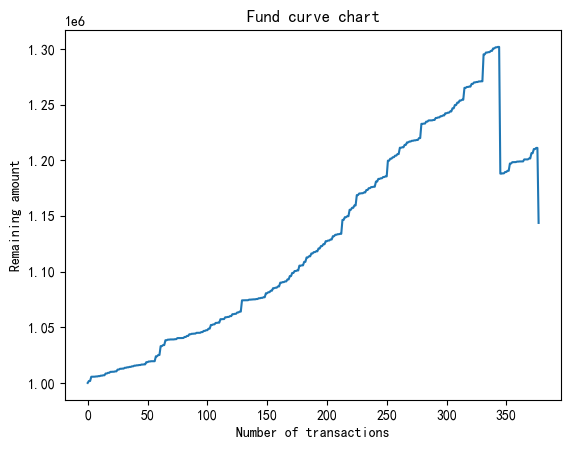

In [39]:
plt.plot(money_list)
plt.xlabel("Number of transactions")
plt.ylabel("Remaining amount")
plt.title("Fund curve chart")
plt.show()

In [40]:
max_drawdown = (max(money_list) - mymoney) / max(money_list)
print(f"最大回撤:{max_drawdown*100}%")

最大回撤:12.144740762826602%
